In [11]:
## ======= ##
## IMPORTS ##
## ======= ##

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay



In [2]:
## ========== ##
## FILE PATHS ##
## ========== ##

csv_file = "/home/jupyter/repos/cloudytile/sandbox/labels.csv"          # Path to your CSV
img_dir = "/home/jupyter/repos/cloudytile/data/2019cw_pngs/"       # Directory containing PNGs



In [3]:
## ======================== ##
## DATASET CLASS DEFINITION ##
## ======================== ##

class PNGDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.df = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.img_dir, row["filename"])
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        label = torch.tensor(row["label_num"], dtype=torch.float32)
        return image, label

    

# specify transforms
img_size = (128,128)
transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])


    
    

In [4]:
## =========== ##
## MODEL SPECS ##
## =========== ##

batch_size = 100
learning_rate = 0.001
num_epochs = 100

In [5]:
## =========== ##
## DATALOADERS ##
## =========== ##

dataset = PNGDataset(csv_file, img_dir, transform)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)




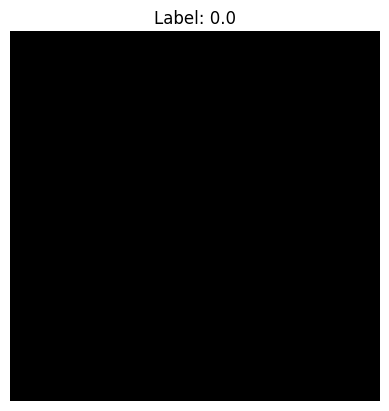

In [10]:
## =========================== ##
## VIEW SAMPLE FROM DATALOADER ##
## =========================== ##

idx_img = 1

# collect batch
images, labels = next(iter(val_loader))

# grab image from batch
img = images[idx_img].cpu().detach()   # shape (3, H, W)

# un-normalize
img = img * 0.5 + 0.5

# clamp to [0,1] for viewing
img = img.clamp(0,1)

# make numpy
img_np = img.permute(1,2,0).numpy()

# plot
plt.imshow(img_np)
plt.title(f"Label: {labels[idx_img].item()}")
plt.axis("off")
plt.show()



In [7]:
## ============== ##
## MODEL DEFINION ##
## ============-= ##

class CloudytileCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * (img_size[0]//8) * (img_size[1]//8), 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x.squeeze(1)
    

In [8]:
## ============ ##
## SEND TO CUDA ##
## ============ ##

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CloudytileCNN().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)



In [9]:
## ============= ##
## TRAINING LOOP ##
## ============= ##


train_losses, val_losses = [], []
train_accs,   val_accs   = [], []

for epoch in range(num_epochs):
    model.train()
    train_loss, train_correct, train_total = 0.0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)
        preds = (torch.sigmoid(outputs) > 0.5).float()
        train_correct += (preds == labels).sum().item()
        train_total += labels.size(0)

    epoch_loss = train_loss / train_total
    epoch_acc = train_correct / train_total
    
    train_losses.append(epoch_loss)
    train_accs.append(epoch_acc)
    
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f} - Acc: {epoch_acc:.4f}")

    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            preds = (torch.sigmoid(outputs) > 0.5).float()
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_epoch_loss = val_loss / val_total
    val_epoch_acc = val_correct / val_total
    
    val_losses.append(val_epoch_loss)
    val_accs.append(val_epoch_acc)
    
    print(f" Val  - Loss: {val_epoch_loss:.4f} - Acc: {val_epoch_acc:.4f}")



Epoch 1/100 - Loss: 0.4870 - Acc: 0.7700
 Val  - Loss: 0.3059 - Acc: 0.8735
Epoch 2/100 - Loss: 0.3395 - Acc: 0.8563
 Val  - Loss: 0.2951 - Acc: 0.8373
Epoch 3/100 - Loss: 0.3150 - Acc: 0.8472
 Val  - Loss: 0.2399 - Acc: 0.8735
Epoch 4/100 - Loss: 0.2779 - Acc: 0.8517
 Val  - Loss: 0.2287 - Acc: 0.8735
Epoch 5/100 - Loss: 0.2535 - Acc: 0.8517
 Val  - Loss: 0.2272 - Acc: 0.8614
Epoch 6/100 - Loss: 0.2406 - Acc: 0.8608
 Val  - Loss: 0.2017 - Acc: 0.9157
Epoch 7/100 - Loss: 0.2213 - Acc: 0.8926
 Val  - Loss: 0.1940 - Acc: 0.8855
Epoch 8/100 - Loss: 0.2126 - Acc: 0.8911
 Val  - Loss: 0.1957 - Acc: 0.8795
Epoch 9/100 - Loss: 0.2177 - Acc: 0.8654
 Val  - Loss: 0.4021 - Acc: 0.8614
Epoch 10/100 - Loss: 0.2625 - Acc: 0.8714
 Val  - Loss: 0.1930 - Acc: 0.8735
Epoch 11/100 - Loss: 0.2088 - Acc: 0.8865
 Val  - Loss: 0.2116 - Acc: 0.8855
Epoch 12/100 - Loss: 0.2082 - Acc: 0.9047
 Val  - Loss: 0.1735 - Acc: 0.9217
Epoch 13/100 - Loss: 0.1835 - Acc: 0.9032
 Val  - Loss: 0.1987 - Acc: 0.8916
Epoch 14

In [12]:
## ============================= ##
## SAVE MODEL AND LOSSES/METRICS ##
## ============================= ##

# losses and accuracies
np.save("/home/jupyter/repos/cloudytile/out/train_losses.npy", np.array(train_losses))
np.save("/home/jupyter/repos/cloudytile/out/val_losses.npy",   np.array(val_losses))
np.save("/home/jupyter/repos/cloudytile/out/train_accs.npy",    np.array(train_accs))
np.save("/home/jupyter/repos/cloudytile/out/val_accs.npy",      np.array(val_accs))

# model state dict
torch.save(model.state_dict(), "/home/jupyter/repos/cloudytile/out/cloudycnn_weights.pth")

# model
torch.save(model, "/home/jupyter/repos/cloudytile/out/cloudycnn_model.pt")


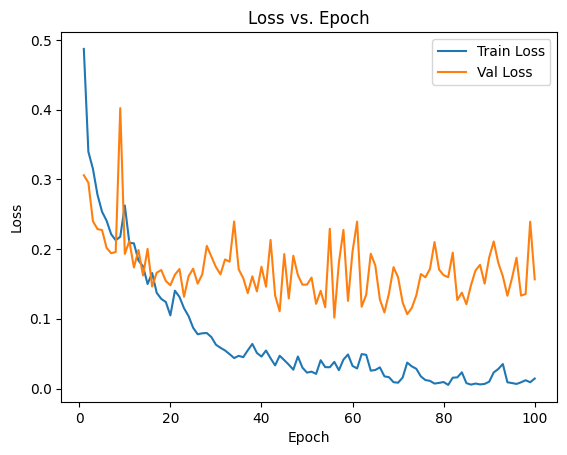

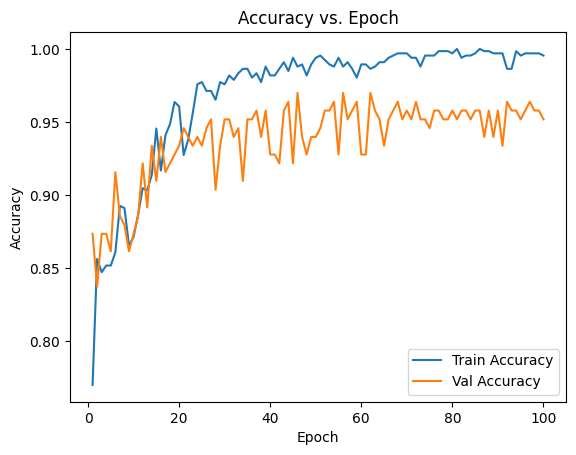

In [13]:
## =========================== ##
## PLOTTING LOSSES AND METRICS ##
## =========================== ##


# loss curves
plt.figure()
plt.plot(range(1, num_epochs+1), train_losses, label="Train Loss")
plt.plot(range(1, num_epochs+1), val_losses,   label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs. Epoch")
plt.legend()
plt.show()

# accuracy curves
plt.figure()
plt.plot(range(1, num_epochs+1), train_accs, label="Train Accuracy")
plt.plot(range(1, num_epochs+1), val_accs,   label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. Epoch")
plt.legend()
plt.show()

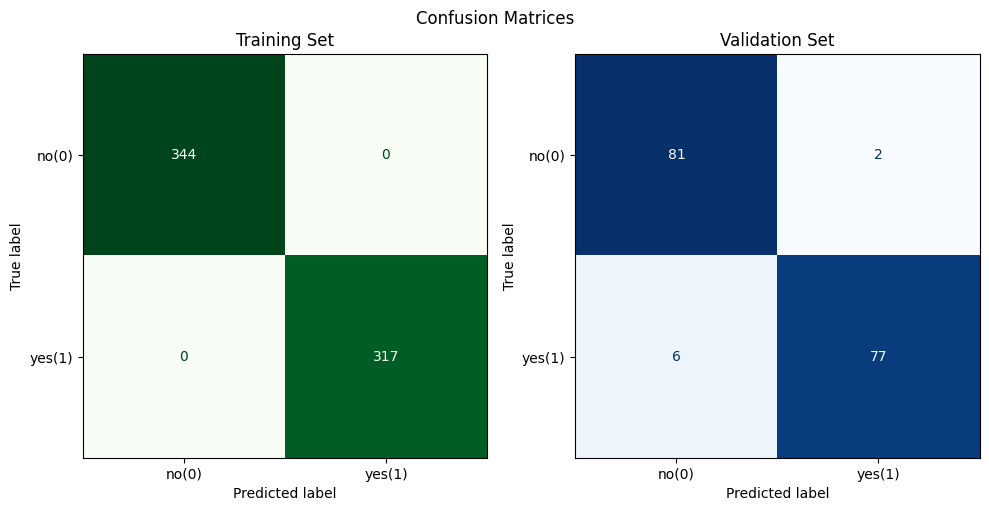

In [15]:
## ================== ##
## CONFUSION MATRICES ##
## ================== ##

# compute training set predictions and true labels
all_train_preds = []
all_train_labels = []
model.eval()
with torch.no_grad():
    for images, labels in train_loader:
        images = images.to(device)
        outputs = model(images)
        preds = (torch.sigmoid(outputs) > 0.5).cpu().numpy().astype(int)
        all_train_preds.extend(preds.tolist())
        all_train_labels.extend(labels.cpu().numpy().astype(int).tolist())

# compute validation set predictions and true labels
all_val_preds = []
all_val_labels = []
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        preds = (torch.sigmoid(outputs) > 0.5).cpu().numpy().astype(int)
        all_val_preds.extend(preds.tolist())
        all_val_labels.extend(labels.cpu().numpy().astype(int).tolist())

# compute confusion matrices
cm_train = confusion_matrix(all_train_labels, all_train_preds, labels=[0,1])
cm_val = confusion_matrix(all_val_labels, all_val_preds, labels=[0,1])

# plot
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=["no(0)", "yes(1)"])
disp_val = ConfusionMatrixDisplay(confusion_matrix=cm_val,   display_labels=["no(0)", "yes(1)"])

disp_train.plot(cmap=plt.cm.Greens, ax=axes[0], colorbar=False)
axes[0].set_title("Training Set")

disp_val.plot(cmap=plt.cm.Blues, ax=axes[1], colorbar=False)
axes[1].set_title("Validation Set")

plt.suptitle("Confusion Matrices")
plt.tight_layout()
plt.show()

